# Lab 4 - Multimodality and embeddings

## Load data

!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/lab4data.zip -o lab4data.zip

!unzip lab4data.zip

## Load model

Load and initialize a model using the huggingface transformers or huggingface hub library. Use this specific model: https://huggingface.co/openai/clip-vit-base-patch32.

In [ ]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Zero-shot classification with CLIP

Zero-shot classification means to perform classification while having seen zero images per class sample before hand. 

Use CLIP to classify the images provided into bears and flowers without doing any finetuning! Show classification results through a confusion matrix.

In [ ]:
import glob

bears = glob.glob("lab4data/bear/*")
flowers = glob.glob("lab4data/flowers/*")
images = bears + flowers

true_labels = ["bear"]*len(bears) + ["flower"]*len(flowers)

classes = "bear", "flower"

In [ ]:
inputs = processor(text=classes, return_tensors="pt", padding=True)

In [ ]:
import torch

with torch.no_grad():
    text_features = model.get_text_features(**inputs)

In [ ]:
from PIL import Image

predicted_labels = []

for img in images:
    image = Image.open(img)

    image_input = processor(images=image, return_tensors='pt')

    with torch.no_grad():
        image_features = model.get_image_features(**image_input)

    logits_per_image = image_features @ text_features.t()

    results = logits_per_image.softmax(dim=1).detach().numpy()

    predicted_idx = results.argmax()

    predicted_labels.append(classes[predicted_idx])

    print(f"Predicted: {classes[predicted_idx]} | Probabilities: {results[0]}")

Predicted: bear | Probabilities: [9.9999714e-01 2.8299582e-06]
Predicted: bear | Probabilities: [9.9999738e-01 2.6229416e-06]
Predicted: bear | Probabilities: [9.9973637e-01 2.6358792e-04]
Predicted: bear | Probabilities: [9.9999893e-01 1.0553483e-06]
Predicted: bear | Probabilities: [9.999957e-01 4.346895e-06]
Predicted: bear | Probabilities: [9.9994385e-01 5.6148809e-05]
Predicted: bear | Probabilities: [9.9993932e-01 6.0732724e-05]
Predicted: bear | Probabilities: [9.9989522e-01 1.0482009e-04]
Predicted: bear | Probabilities: [9.992151e-01 7.849023e-04]
Predicted: bear | Probabilities: [9.9999249e-01 7.5186194e-06]
Predicted: bear | Probabilities: [9.9999571e-01 4.2736215e-06]
Predicted: bear | Probabilities: [9.9999797e-01 2.0023535e-06]
Predicted: bear | Probabilities: [9.999932e-01 6.844389e-06]
Predicted: bear | Probabilities: [9.9999976e-01 1.8881568e-07]
Predicted: bear | Probabilities: [9.9998999e-01 1.0048955e-05]
Predicted: bear | Probabilities: [9.9999964e-01 3.7619296e-07

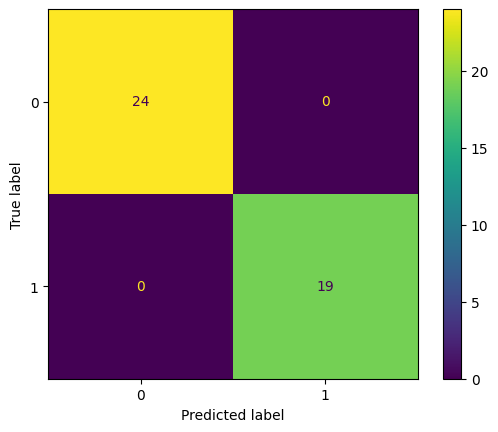

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusionmatrix = confusion_matrix(true_labels, predicted_labels)

ConfusionMatrixDisplay(confusionmatrix).plot()

## Feature extraction using ResNet

Zero-shot classification works as it does, because it makes use of a well-conditioned latent space where all images are semantically separable. Prove that you can do something similar to the previous section using any image backbone!

Use the same ResNet backbone in the past few labs (Resnet34 w/o last two layers) and perform feature extraction for each image. Show me how many subclasses of bears are there in this dataset. 

Hint: Week5 lecture.

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

resnet34 = models.resnet34(pretrained=True)
backbone = nn.Sequential(*list(resnet34.children())[:-2])
backbone.eval()

c:\Users\ochon\.conda\envs\maio\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ochon\.conda\envs\maio\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
from torchvision import transforms
from PIL import Image
import os
import numpy as np

transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

features = []
for img in images:
    image = Image.open(img)
    img_tensor = transform(image).unsqueeze(0)  # Add batch dim
    with torch.no_grad():
        feat = backbone(img_tensor).squeeze().numpy()  # Shape: [C, H, W]
        features.append(feat)

In [ ]:
import numpy as np

feature_matrix = np.array([np.mean(feat, axis=(1, 2)) for feat in features])  # Shape: [N, C]

In [ ]:
from sklearn.cluster import KMeans

# Estimate number of bear subclasses — let's say we try with 3 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(feature_matrix)

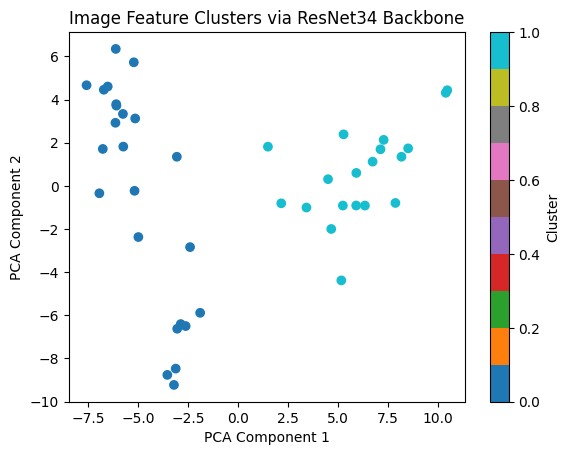

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(feature_matrix)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='tab10', marker='o')
plt.title("Image Feature Clusters via ResNet34 Backbone")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()

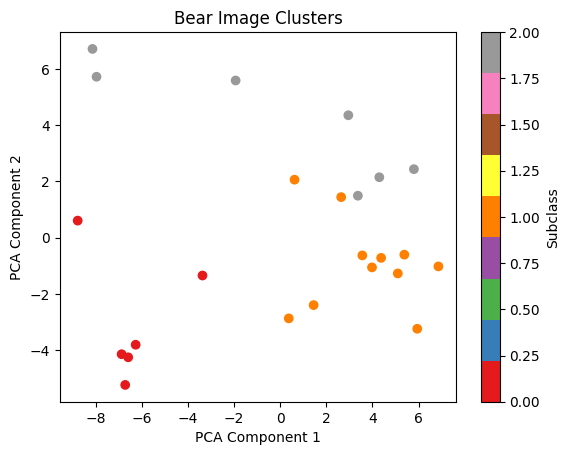

In [ ]:
bear_indices = [i for i, label in enumerate(true_labels) if label == "bear"]
bear_features = feature_matrix[bear_indices]

# Now cluster only bears
bear_kmeans = KMeans(n_clusters=3, random_state=42)
bear_clusters = bear_kmeans.fit_predict(bear_features)

# Visualize bear clusters
pca_bear = PCA(n_components=2)
bear_reduced = pca_bear.fit_transform(bear_features)

plt.scatter(bear_reduced[:, 0], bear_reduced[:, 1], c=bear_clusters, cmap='Set1')
plt.title("Bear Image Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Subclass')
plt.show()

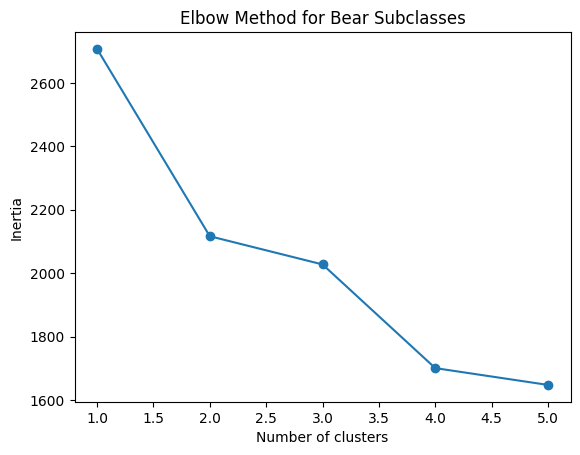

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

inertias = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(bear_features)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 6), inertias, marker='o')
plt.title("Elbow Method for Bear Subclasses")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

## Debiasing vectors in latent space

Realize that the functionality of CLIP rests upon its capability to map both images and text into the same latent space. Learning how to navigate latent spaces is key to making best use of them. Fortunately this is quite learnable. Each instance of data, in this case images, are represented by vectors of size (N, ) where N is the dimension of the latent space. If you can learn Euclid's art of geometry, you can navigate latent spaces.

This 2016 paper, "Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings" (https://arxiv.org/pdf/1607.06520) shows that:

1. Vector differences between word embeddings can represent relationships between words,
2. Gender biases derived from linguistic use of specific terms can be quantified in these words!

If you take the word embedding vector of man and minus the word embedding vector of woman, this difference is numerically close to the word embedding vectors of king minus queen. This is a more innocuous example as king and queen are historically gendered roles and are appropriately accurate. The paper discovered that this gender bias is baked into a lot more words that might not accurately reflect modern progressive views on gender.

Before we go further, let me explain some small differences in terminology. 

- This article used word embeddings derived from the word2vec embedder. Word2vec is trained by calculating the co-occurence of words in a corpus. If two words are seen together very often, they will have embeddings that are close, and vice versa. CLIP's embeddings are trained differently, and can allow embedding more than one word.
- Note that the terminology for many things in machine learning are still fast and loose, so use of terms are not very standardized among practitioners. In this case, embedding space and latent space are very very similar with small differences! On one hand, we describe the vector space where data points (in this case images) are transformed into vector representations where the distance among items reflect their semantic differences. On the other hand, any output of an intermediate layer in any neural network can be said to be projecting into a latent space. In real life usage, I think these terms are mixed up enough that it suffices for you to know that they tend to mean the same thing.

Let us attempt to replicate the findings of this paper using CLIP's text embeddings. Calculate a measure of gender inclination for the following phrases, then perform debiasing afterwards and show that the debiased vector shows perfectly neutral gender inclination.

- "A modest pope"
- "A haughty unicorn"
- "A fanciful flower"
- "A ferocious bear"

You can use any method to measure gender inclination, as long as it reflects how much closer is the phrase to the concept of male vs to the concept of female.

In [8]:
import torch
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

for i in ["A modest pope", "A haughty unicorn", "A fanciful flower", "A ferocious bear", "A nurturing mother"]:

    inputs = processor(text=[i, "man", "woman"], return_tensors="pt", padding=True)

    with torch.no_grad():
        embeddings = model.get_text_features(**inputs)
    
    print((embeddings[0] @ embeddings[2]) - (embeddings[0] @ embeddings[1]))

#negative result = more male-ish
#positive result = more female-ish

tensor(-5.3158)
tensor(-1.3964)
tensor(-1.4055)
tensor(-5.3265)
tensor(1.5266)


## EX: Most opposite word

Find a single word from CLIP's vocabulary that will give the shortest distance with the embedding of the phrase: "shortest path between two points". Make sure that the word is represented by its own token when passed through CLIP's tokenizer. In other words, when passed through CLIP's tokenizer, we should only see three tokens: token 49406, the word's own token, and token 49407.

In [ ]:
import torch
import matplotlib.pyplot as plt
from transformers import CLIPModel, CLIPTokenizer

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model and tokenizer
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Input phrase
phrase = "shortest path between two points"

# Get all tokens in vocabulary and filter valid single-word tokens
vocab = list(tokenizer.get_vocab().keys())
candidates = [word.replace("</w>", "") for word in vocab]

with open('vocab.txt', 'w') as f:
    for line in candidates:
        f.write(f"{line}\n")

print(candidates)

# Encode phrase
phrase_inputs = tokenizer(phrase, return_tensors="pt").to(device)
p_enc = model.get_text_features(**phrase_inputs).to(device)

# Store similarities
similarities = []

# Compute similarities
for word in candidates:
    tokenized = tokenizer(word, return_tensors="pt").to(device)
    if len(tokenizer(word)["input_ids"]) != 3:
        continue  # skip non-single-token words
    
    with torch.no_grad():
        w_enc = model.get_text_features(**tokenized).to(device)
    
    sim = torch.nn.functional.cosine_similarity(p_enc, w_enc).item()
    similarities.append((word, sim))

# Sort by similarity
similarities.sort(key=lambda x: x[1], reverse=True)

# Print top and bottom matches
top_n = 10
print(f"\nTop {top_n} matches:")
for word, score in similarities[:top_n]:
    print(f"{word}: {score:.4f}")

print(f"\nBottom {top_n} matches:")
for word, score in similarities[-top_n:]:
    print(f"{word}: {score:.4f}")

# Plot top N matches
words, scores = zip(*similarities[:top_n])

plt.figure(figsize=(10, 6))
plt.barh(words, scores, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.title('Top Words Similar to Phrase: "shortest path between two points"')
plt.xlim(min(scores) - 0.05, max(scores) + 0.05)
plt.gca().invert_yaxis()  # Highest at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ë', 'Ì', 'Í', 'Î', 'Ï', 'Ð', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ', 'Ā', 'ā', 'Ă', 'ă', 'Ą', 'ą', 'Ć', 'ć', 'Ĉ', 'ĉ', 'Ċ', 'ċ'